In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from resources.tokTT import CommentTokenizer as CT
from resources.basicIO import InputOutput as IO
from resources.filterLang import FilterLanguage as FL
from resources.expansion import Expand_U
from resources.fasttext_transformer import classify
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import fasttext
from scipy import spatial
from scipy.spatial import distance
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import LassoLars
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
import copy
import scipy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay


[nltk_data] Downloading package wordnet to C:\Users\AJAY
[nltk_data]     BISWAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Fasttext Unsupervised Model

In [2]:
model_2 = fasttext.load_model("models/ft_unsupervised_N_2.bin")
model_3 = fasttext.load_model("models/ft_unsupervised_N_3.bin")


### Load Dataset

In [3]:
df_sample = pd.read_csv("datasets/random_sample_data.csv")
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample['label'].value_counts()


0    1846
1    1408
Name: label, dtype: int64

In [4]:
X_raw = df_sample['tokenized_comment']
y = df_sample['label']

X_2 = [model_2[x] for x in X_raw ]
X_3 = [model_3[x] for x in X_raw ]


### Train Test Split

In [46]:
# modify here to change models
X = X_2
model = model_2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=25,
                                                    stratify=y)


In [47]:
print(len(X_train))
print(len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())


2603
651
0    1477
1    1126
Name: label, dtype: int64
0    369
1    282
Name: label, dtype: int64


### Validation Curve

### https://vitalflux.com/validation-curves-explained-python-sklearn-example/

In [48]:
classifiers = {
    "SVM": make_pipeline(StandardScaler(), svm.SVC(probability=True)),
    "KNN": KNeighborsClassifier(n_neighbors=20),
    "LR": make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=2))
}


In [49]:
param_range = [0.001, 0.05, 0.1, 0.5, 1.0]
train_scores, test_scores = validation_curve(estimator=classifiers["LR"],
                                             X=X_train, y=y_train,
                                             cv=10,
                                             param_name='logisticregression__C', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


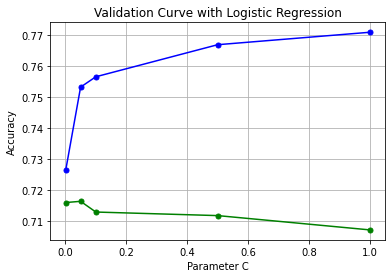

In [50]:
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with Logistic Regression')
plt.savefig('outputs/figures/' + 'Validation Curve with Logistic Regression + N2',
            dpi=300, bbox_inches='tight')
plt.show()


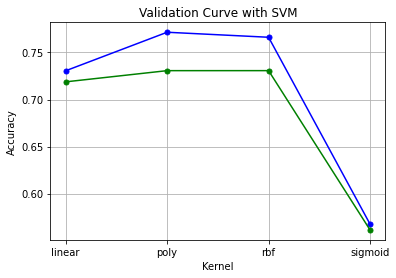

In [51]:
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = validation_curve(estimator=svm.SVC(),
                                             X=X_train, y=y_train,
                                             cv=10,
                                             param_name='kernel', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with SVM')
plt.savefig('outputs/figures/' + 'Validation Curve with SVM + N2',
            dpi=300, bbox_inches='tight')
plt.show()


In [52]:
svm.SVC().get_params().keys()


dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

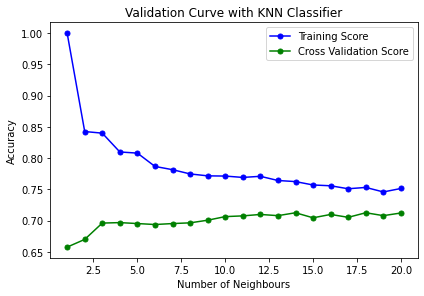

In [53]:
parameter_range = np.arange(1, 21, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=10, scoring="accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         marker='o', markersize=5,
         color='blue',
         label="Training Score")
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", 
         marker='o', markersize=5,
         color='green')

# Creating the plot
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.title('Validation Curve with KNN Classifier')
plt.savefig('outputs/figures/' + 'Validation Curve with KNN Classifier + N2',
            dpi=300, bbox_inches='tight')
plt.show()


### Active Learning

In [54]:
X_seed, X_expand, y_seed, y_expand = train_test_split(X_train,
                                                      y_train, test_size=0.99,
                                                      random_state=41,
                                                      stratify=y_train)


In [55]:
print('X_seed: ',len(X_seed))
print('X_expand: ',len(X_expand))

X_seed:  26
X_expand:  2577


In [56]:
y_seed.value_counts()


0    15
1    11
Name: label, dtype: int64

### Uncertainty Sampling

In [67]:

X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model,
                                                                                classifiers["SVM"],
                                                                                list(
                                                                                    X_seed),
                                                                                list(
                                                                                    y_seed),
                                                                                list(
                                                                                    X_expand),
                                                                                list(
                                                                                    y_expand),
                                                                                20,
                                                                                5
                                                                                )


In [68]:
print(len(X_uncertain_exp_u))

666


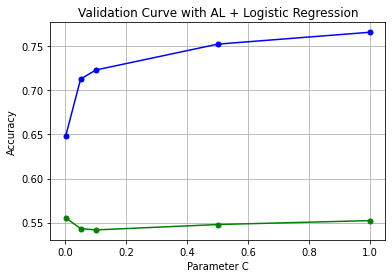

In [69]:
param_range = [0.001, 0.05, 0.1, 0.5, 1.0]
train_scores, test_scores = validation_curve(estimator=classifiers["LR"],
                                             X=X_uncertain_exp_u, y=y_uncertain_exp_u,
                                             cv=10,
                                             param_name='logisticregression__C', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with AL + Logistic Regression')
plt.savefig('outputs/figures/' + 'Validation Curve with AL_SVM + Logistic Regression + N2',
            dpi=300, bbox_inches='tight')
plt.show()


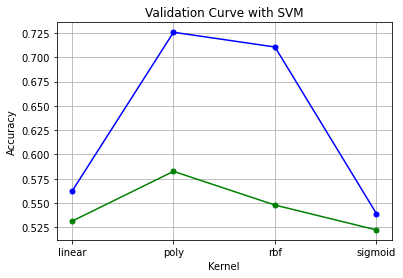

In [70]:
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = validation_curve(estimator=svm.SVC(),
                                             X=X_uncertain_exp_u, y=y_uncertain_exp_u,
                                             cv=10,
                                             param_name='kernel', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with SVM')
plt.savefig('outputs/figures/' + 'Validation Curve with AL_SVM + SVM + N2',
            dpi=300, bbox_inches='tight')
plt.show()


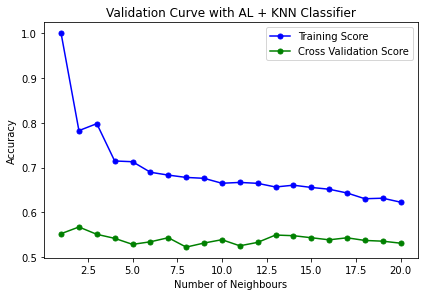

In [71]:
parameter_range = np.arange(1, 21, 1)
train_score, test_score = validation_curve(classifiers["KNN"], X_uncertain_exp_u, y_uncertain_exp_u,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=10, scoring="accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         marker='o', markersize=5,
         color='blue',
         label="Training Score")
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score",
         marker='o', markersize=5,
         color='green')

# Creating the plot
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.title('Validation Curve with AL + KNN Classifier')
plt.savefig('outputs/figures/' + 'Validation Curve with AL_SVM + KNN Classifier + N2',
            dpi=300, bbox_inches='tight')
plt.show()
